In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import weinberg
import distr
import common
import emcee

In [4]:
PHI_RANGE     = [40,50]
THETA_RANGE   = [0.5,1.5]
DATA_RANGE    = [-1,1] 
THE_SIMULATOR = weinberg.simulator

# Introducing the Model p(x|$\theta$,$\Phi$)

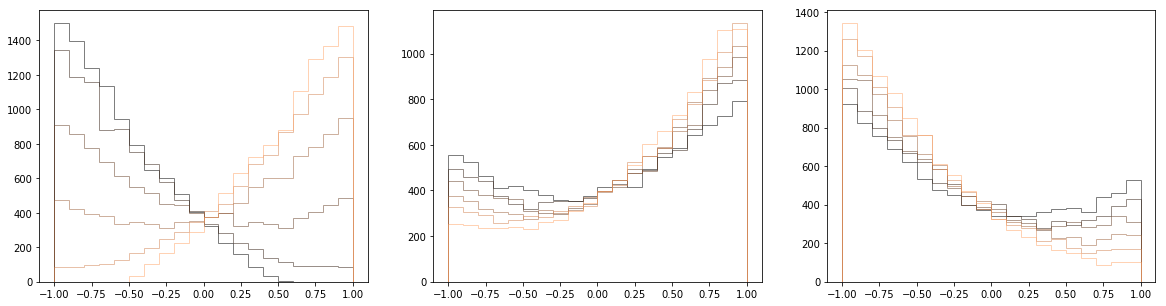

In [5]:
cm = plt.get_cmap('copper')
fig,axarr = plt.subplots(1,3)
fig.set_size_inches(20,5)
bins = np.linspace(*DATA_RANGE, num = 21)

nsteps_phi, theta_nom = 6, 1.5
for i,phi in enumerate(np.linspace(*PHI_RANGE,num = nsteps_phi)):
    _=axarr[0].hist(weinberg.simulator(theta_nom,phi,10000), bins = bins, color = cm(i/float(nsteps_phi)), alpha = 0.5, histtype='step')

nsteps_theta, phi_nom = 6, 47
for i,theta in enumerate(np.linspace(*THETA_RANGE,num = nsteps_theta)):
    _=axarr[1].hist(weinberg.simulator(theta,phi_nom,10000), bins = bins, color = cm(i/float(nsteps_phi)), alpha = 0.5, histtype='step')
    
nsteps_theta, phi_nom = 6, 42
for i,theta in enumerate(np.linspace(*THETA_RANGE,num = nsteps_theta)):
    _=axarr[2].hist(weinberg.simulator(theta,phi_nom,10000), bins = bins, color = cm(i/float(nsteps_phi)), alpha = 0.5, histtype='step')

# An Example Experiment
## Taking Data

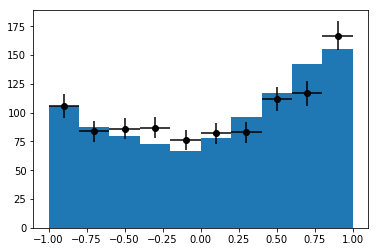

In [7]:
example_phi = 47
example_theta = 0.55
example_ndata = 1000


bins = np.linspace(*DATA_RANGE, num = 11)
example_data = common.collect_data(example_phi,weinberg.simulator, theta_nature=example_theta, n_samples = example_ndata)
datacounts,bins = np.histogram(example_data,bins = bins)
centers = bins[:-1] + (bins[1:]-bins[:-1])/2.
plt.errorbar(centers,datacounts,fmt = 'o',xerr = (bins[1:]-bins[:-1])/2.,yerr = np.sqrt(datacounts), c = 'k')

n_mc = 10000
mc = weinberg.simulator(example_theta,example_phi,n_mc) #simulate much more than data
mccounts,_,_ = plt.hist(mc,weights = [float(example_ndata)/float(n_mc)]*n_mc, bins = bins)


0.1
0.1


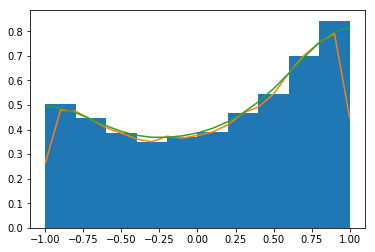

In [8]:
samples = weinberg.simulator(example_theta,example_phi,10000)
p = distr.Distribution(
    name = 'example_simulation',
    samples = samples,
    range = DATA_RANGE)

p.hist(bins = 10, normed = True)

xs = np.linspace(*DATA_RANGE,num = 21)
logpdf_nomirr = p.approx_logpdf()
logpdf_mirror = p.approx_logpdf(mirror = True, mirror_shifts=[-2,2])

plt.plot(xs,np.exp(logpdf_nomirr(xs)))
plt.plot(xs,np.exp(logpdf_mirror(xs)))

## The likelihood $p(x|\theta,\Phi)$ and the prior $p(\theta|\Phi)$

0.1
0.1
0.1
0.1
0.1
0.1


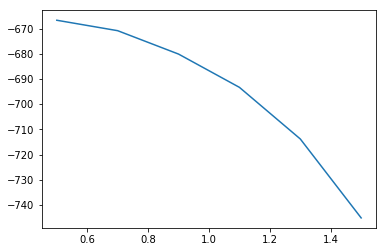

In [9]:
test_thetas = np.linspace(0.5,1.5,6)

reload(common)
reload(weinberg)
reload(distr)
import multiprocessing
pool = multiprocessing.Pool(4)


nll = [pool.apply_async(common.lnlike,
                        args = (theta_test,example_data,example_phi),
                        kwds = dict(
                         simulator=weinberg.simulator,
                         simulation_kwargs = {'n_samples': 10000},
                         distr_kwargs =  {'range': DATA_RANGE},
                         logpdf_kwargs = {'mirror': True, 'mirror_shifts': [-2,2]}
                        )
                       ) for theta_test in test_thetas]
[r.ready() for r in nll]

pool.close()
pool.join()
plt.plot(test_thetas,[r.get() for r in nll])

0.1


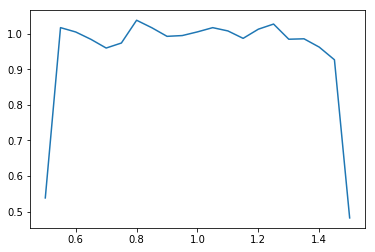

In [10]:
reload(distr)
example_prior = distr.Distribution('prior',range = THETA_RANGE)
xs = np.linspace(*THETA_RANGE,num = 21)
logpdf = example_prior.approx_logpdf()
plt.plot(xs,np.exp(logpdf(xs)))

## The posterior $p(\theta|x,\Phi)$

In [ ]:
import emcee
reload(distr)
reload(common)
ndim, nwalkers = 1, 10
pos = [np.array([x]) for x in np.random.uniform(0.5,1.5,size=nwalkers)]
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, common.lnprob,
    args=(
        example_data,example_prior,example_phi,weinberg.simulator,
        dict(simulation_kwargs = {'n_samples': 10000},
             distr_kwargs =  {'range': DATA_RANGE},
             logpdf_kwargs = {'mirror': True, 'mirror_shifts': [-2,2]}
            )
        )
    )
_ = sampler.run_mcmc(pos, 50)

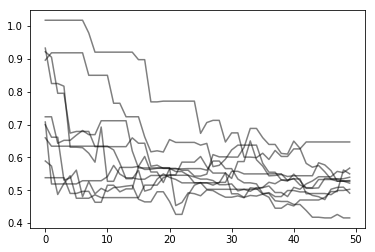

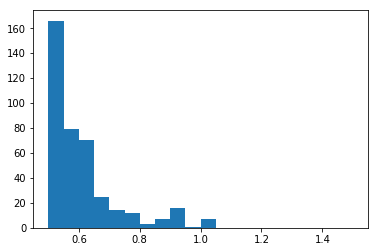

In [20]:
samples = sampler.chain
for x in samples:
    plt.plot(x, alpha = 0.5, c = 'k')
plt.show()
_=plt.hist(sampler.flatchain, bins = np.linspace(*THETA_RANGE,num = 21))

In [ ]:
def simulator(theta,phi,n_samples):
    return rej_sample_costheta(n_samples,phi,theta)


def collect_data(phi, n_samples = 500):
    THETA_NATURE = 1.4
    return simulator(THETA_NATURE,phi,n_samples)

In [ ]:
def lnprior(theta, prior):
    p = prior.pdf(theta)
    if p <= 1e-8:
        return -np.inf
    else:
        return np.log(p)

def lnlike(theta, x, phi):
    mc = rej_sample_costheta(1000,phi,theta)
    logpdf = approx_logpdf(mc)
    return np.sum(logpdf(x))

def lnprob(theta, x, prior, phi):
    lp = lnprior(theta, prior)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, phi)

In [ ]:
def calculate_posterior(prior, data, phi):
    """Compute samples from the posterior"""
    ndim, n_walkers = 1, 10
    # initialise walkers from the MAP + noise
    # XXX alternatively sample a point from the KDE without adding noise?
    # XXX not sure if the noise takes us into a region where the prior is zero?
    pos = [prior.map() + 1e-1*np.random.randn(ndim) for i in range(n_walkers)]
    
    sampler = emcee.EnsembleSampler(n_walkers, 1, lnprob, args=(data, prior, phi))
    pos, prob, state = sampler.run_mcmc(pos, 10)
    
    sampler.reset()
    pos, prob, state = sampler.run_mcmc(pos, 50)
    
    return Distribution(prior.name, prior.range, sampler.flatchain)

In [ ]:
## initialize first prior as uniform between 0.5 and 1.5
from prior_dist import Distribution
prior_theta = Distribution('p(theta)', range=(0.5,1.5), samples=np.random.uniform(0.5, 1.5, 100000))

# Single Science Loop Body

In [ ]:
phi = 47
real_data = collect_data(phi,n_samples=100)
posterior = calculate_posterior(prior_theta,real_data,phi)

In [ ]:
plt.hist(posterior.samples,normed = True,range = (0.5,1.5),bins = 20)
prior_theta.plot()
posterior.plot()
plt.axvline(posterior.map(bins = 20), c = 'k')
print 'MAP',posterior.map(bins = 20)

In [ ]:
from multiprocessing import Pool

def info_gain(p1, p2):
    return p1.entropy() - p2.entropy()

def _simulate(args):
    theta_map, phi, prior = args
    print 'simulating with ',theta_map, phi
    # external workflow provides simulated data
    sim_data = simulator(theta_map, phi, n_samples = 1000)

    #external workflow uses simulator to provide likelihood 
    sim_posterior = calculate_posterior(prior, sim_data, phi)
    return info_gain(prior, sim_posterior)


def expected_information_gain(phi, prior,bins = 20):
    'calculate the expression above using workflow for simulations'
    n_simulations = 4
    
    phi = phi[0]
    #need to pass in prior through some extra arguments
    
    # use saddle-point approximation
    theta_map = prior.map(bins = bins)

    # currently the MCMC sampler is the slower part, which already uses threads so we don't gain
    # this should change once we have a more realistic simulator that takes time to run
    pool = Pool(n_simulations)
    eig = pool.map(_simulate, [(theta_map, phi, prior) for i in range(n_simulations)])
    pool.close()
    pool.join()
    return np.mean(eig)

In [ ]:
eig = []
for x in np.linspace(40,50,11).reshape(-1,1):
    eig.append(expected_information_gain(x,posterior))


In [ ]:
plt.plot(np.linspace(40,50,11),eig)

In [ ]:
#use scikit-optimize to optimize phi
from skopt import gp_minimize


def design_next_experiment(prior):
    bounds = [(40,50)]
    n_calls = 10
    
    func = lambda p: -expected_information_gain(p, prior)

    # five random points to initialise things, then five using the GP model
    # XXX Should we be reusing the random number generator? Means this call eseentially evaluates
    # XXX the same values of phi each science iteration
    opt_result = gp_minimize(func, bounds, n_random_starts=5, n_calls=n_calls, random_state=4)

    return opt_result, opt_result.x[0], opt_result.x_iters

In [ ]:
res = design_next_experiment(posterior)

In [ ]:
smoothx = np.linspace(40,50).reshape(-1,1)
y,std = res[0].models[-1].predict(smoothx, return_std = True)
y,std = -y,-std
plt.plot(smoothx[:,0],y, c = 'k')
plt.plot(smoothx[:,0],y+std, c = 'k', linestyle = 'dashed')
plt.plot(smoothx[:,0],y-std, c = 'k', linestyle = 'dashed')
plt.fill_between(smoothx[:,0],y-std,y+std, color = 'k', alpha = 0.2)
plt.scatter(res[0].x_iters,-res[0].func_vals, marker = '.', s = 200, color = 'k')
plt.axvline(res[0].x, c = 'r')

In [ ]:
res[0].x_iters